In [2]:
import pandas as pd
import datetime as dt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import numpy as np
from uszipcode import SearchEngine
import seaborn as sns
import pickle
%matplotlib inline

# Load the Data

In [3]:
df = pd.read_csv("data/assessments.csv",low_memory=False)
pd.set_option('display.max_rows', 200)

In [4]:
# prepare the data 
# the zipcode information contains a typo at row 142359
df1 = df.copy()
df1 = df1.dropna(how='all')
df1 = df1.dropna(subset=['SALEPRICE', 'SALEDATE','PROPERTYCITY','PROPERTYZIP'])
df1 = df1.reset_index(drop=True)
df1.at[142359,'PROPERTYZIP'] =  15017.
df1['year'] = df1['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y').year)
df1['month'] = df1['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y').month)
df1['PROPERTYZIP'] = df1['PROPERTYZIP'].astype('int')
df1['PROPERTYZIP'] = df1['PROPERTYZIP'].astype('str')
df1 = df1[df1.SALEPRICE>10].reset_index(drop = True)

In [5]:
def get_location(df):
    engine = SearchEngine()
    zipcode_dict = {}
    for zipcode in df['PROPERTYZIP'].unique():
        try:
            zc = engine.by_zipcode(zipcode)
            zipcode_dict[zipcode] = [zc.lng, zc.lat]
        except:
            print(zipcode)
            zipcode_dict[zipcode] = [np.nan, np.nan]
    return zipcode_dict

In [6]:
def school_map(df):
    school_ranking = ['North Allegheny', 'Mt Lebanon','Fox Chapel Area','Upper St Clair','South Fayette Twp','Hampton Township','Quaker Valley',
                    'Montour','Pine-Richland','Moon Area','North Hills','Plum Boro','Bethel Park','Riverview','West Jefferson Hills',
                    'Keystone Oaks','Elizabeth Forward','Baldwin Whitehall','Gateway','West Allegheny','South Park','Avonworth','Shaler Area',
                    'Chartiers Valley','Northgate', 'Deer Lakes','Brentwood Boro','Pittsburgh', 'Woodland Hills', 'Steel Valley','Carlynton', 
                    'McKeesport Area','West Mifflin Area','Penn Hills Twp', 'Cornell','Highlands','East Allegheny', 'Clairton City',
                    'Allegheny Valley', 'Sto-Rox', 'South Allegheny','Wilkinsburg Boro']
    ranking = [x for x in range(1,len(school_ranking)+1)]
    ranking_dict = dict(zip(school_ranking, ranking))
    school_missing = [x for x in df.SCHOOLDESC.unique() if x not in school_ranking]
    missing_map = {}
    for zc in df.PROPERTYZIP.unique():
        schools = list(df[df['PROPERTYZIP']==zc]['SCHOOLDESC'].unique())
        for s in schools:
            if s in school_missing:
                if s not in missing_map:
                    missing_map[s] = schools
                    missing_map[s].remove(s)
                else:
                    missing_map[s] += schools
                    missing_map[s].remove(s)
    for key in missing_map:
        missing_map[key] = np.array(list(map(ranking_dict.get, missing_map[key]))).mean()
        school_ranking_dict = dict(zip(list(missing_map.keys())+list(ranking_dict.keys()),list(missing_map.values())+list(ranking_dict.values())))
    return dict(zip(list(missing_map.keys())+list(ranking_dict.keys()),list(missing_map.values())+list(ranking_dict.values())))


In [7]:
# map zip code to longitude and latitude
# map school district to ranking number
zipcode_dict = get_location(df1)
school_ranking_dict= school_map(df1)

In [8]:
class Features_Transformer(object):
    """Class that transform categorical features into numeric features and fill the missing data.
    
    Data cleaning process of trasform original features to numeric features.
    Dummy transform is at the end of the process.
    
    Attributes:
        zipcode_dict: hash map between zip code and longitude, latitude
        school_ranking_dict:  hash map between school district and ranking
    """
    
    def __init__(self, zipcode_dict, school_ranking_dict): 
        
        """Inits Features_Transformer"""
        
        self.zipcode_dict = zipcode_dict
        self.school_ranking_dict = school_ranking_dict 
        
        # ranking list to transform categorical features with ranking
        self.grade_ranking_list = ['XX+','XX','XX-','X+','X','X-','A+','A','A-','B+','B','B-',
                                   'C+','C','C-','D+','D','D-','E+','E','E-']
        self.CDU_ranking_list = ['EXCELLENT', 'VERY GOOD', 'GOOD','AVERAGE','FAIR', 'POOR',
                                 'VERY POOR','UNSOUND']
        
        self.feature_location = []
        self.feature_mean = []
        # 
        self.cat_features = ['TAXDESC','TAXSUBCODE_DESC','OWNERDESC','CLASSDESC','SALEDESC', 
                             'STYLEDESC','EXTFINISH_DESC','ROOFDESC','BASEMENTDESC',
                             'HEATINGCOOLINGDESC']
        self.missing_numeric_features = ['FIREPLACES', 'BSMTGARAGE', 'HALFBATHS', 'ROOF', 
                                         'FULLBATHS', 'BASEMENT', 'TOTALROOMS', 'CONDITION', 
                                         'BEDROOMS', 'EXTERIORFINISH', 'STORIES', 
                                         'FINISHEDLIVINGAREA', 'CARDNUMBER', 'YEARBLT' ]
        self.additional_feature = ['MUNICODE', 'SCHOOLCODE', 'OWNERCODE', 'USECODE', 'LOTAREA', 
                                   'COUNTYBUILDING', 'COUNTYLAND', 'COUNTYTOTAL', 'COUNTYEXEMPTBLDG', 
                                   'LOCALBUILDING', 'LOCALLAND', 'LOCALTOTAL', 'FAIRMARKETBUILDING', 
                                   'FAIRMARKETLAND', 'FAIRMARKETTOTAL']

        self.dummy_features = ['TAXDESC','TAXSUBCODE_DESC', 'OWNERDESC', 'CLASSDESC', 'SALEDESC', 
                               'STYLEDESC','EXTFINISH_DESC','ROOFDESC','BASEMENTDESC',
                               'HEATINGCOOLINGDESC']

    
    def fit(self, X, y=None):
        """fit the features"""
        
        df = pd.DataFrame()
        
        # combine the address
        df['PROPERTYHOUSENUM'] = X['PROPERTYHOUSENUM'].astype('str')
        df['PROPERTYADDRESS'] = X['PROPERTYADDRESS']
        df['PROPERTYCITY'] = X['PROPERTYCITY']
        df['PROPERTYSTATE'] = X['PROPERTYSTATE']
        df['PROPERTYZIP'] = X['PROPERTYZIP'].astype('int')
        df['PROPERTYZIP'] = df['PROPERTYZIP'].astype('str')
        df['address'] = df[['PROPERTYHOUSENUM','PROPERTYADDRESS','PROPERTYCITY','PROPERTYSTATE','PROPERTYZIP']].agg(' '.join, axis=1)
        
        # drop useless features after getting the address
        df = df.drop(columns=['PROPERTYHOUSENUM', 'PROPERTYADDRESS', 'PROPERTYCITY','PROPERTYSTATE'])
        
        # fill the missing date with the later one
        df['PREVSALEDATE'] = X['PREVSALEDATE'].fillna(X['SALEDATE'])
        df['PREVSALEDATE2'] = X['PREVSALEDATE2'].fillna(df['PREVSALEDATE'])
        
        # fill the missing dale price with the later one
        df['SALEPRICE'] = X['SALEPRICE']
        df['PREVSALEPRICE'] = X['PREVSALEPRICE'].fillna(X['SALEPRICE'])
        df['PREVSALEPRICE2'] = X['PREVSALEPRICE2'].fillna(df['PREVSALEPRICE'])
         
        # change date features to datetime object
        df['SALEDATE'] = X['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE'] = df['PREVSALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE2'] = df['PREVSALEDATE2'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        
        # adding timestamp from datetime object
        df['Timestamp0'] = df['SALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp1'] = df['PREVSALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp2'] = df['PREVSALEDATE2'].apply(lambda x: x.timestamp())
        
        # drop datetime object
        df = df.drop(columns=['SALEDATE', 'PREVSALEDATE','PREVSALEDATE2'])
        
        # map the school ranking hashmap to school disctrict
        df['SCHOOL_Ranking'] = X['SCHOOLDESC'].map(school_ranking_dict)
        
        # change binary categorical features to 0 and 1
        # missing value is 0
        df['HOMESTEADFLAG'] = X['HOMESTEADFLAG'].notnull().astype('int')
        df['FARMSTEADFLAG'] = X['FARMSTEADFLAG'].notnull().astype('int')
        df['CLEANGREEN'] = X['CLEANGREEN'].notnull().astype('int')
        df['ABATEMENTFLAG'] = X['ABATEMENTFLAG'].notnull().astype('int')
        
        # map the zip code to longitude, latitude 
        # get the locations to fill other features' missing values
        df['longitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][0])
        df['latitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][1])
        df['location']=list(zip(df['longitude'], df['latitude']))
        
        # map GRADE features with ranking
        # fill missing values with location information
        # if anything else is missing, fill it with the mean
        df['GRADE'] = X['GRADE'].map(dict(zip(self.grade_ranking_list, range(1,len(self.grade_ranking_list)+1))))
        self.grade_mean = df['GRADE'].mean()
        self.grade_location =df['location'].map(df[['location','GRADE']].dropna().groupby('location').mean().to_dict()['GRADE'])
        df['GRADE'] = df['GRADE'].fillna(self.grade_location)
        df['GRADE'] = df['GRADE'].fillna(self.grade_mean)
        
        # map CDU features with ranking
        # fill missing values with location information
        # if anything else is missing, fill it with the mean
        df['CDUDESC'] = X['CDUDESC'].map(dict(zip(self.CDU_ranking_list, range(1,len(self.CDU_ranking_list)+1))))
        self.CDU_mean = df['CDUDESC'].mean()
        self.CDU_location = df['location'].map(df[['location','CDUDESC']].dropna().groupby('location').mean().to_dict()['CDUDESC'])
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_location)
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_mean)
        
        # replace None values with NaN in cat_features,
        # prepare for dummy transform
        for feature in self.cat_features:
            df[feature] = X[feature].replace('None',np.nan)
        
        # replace special None values with NaN
        # prepare for dummy transform
        df['CLASSDESC'] = X['CLASSDESC'].replace('OTHER','CLASS_OTHER')
        df['SALEDESC'] = X['SALEDESC'].replace('OTHER','SALE_OTHER')
        df['STYLEDESC'] = X['STYLEDESC'].replace('OTHER','STYLE_OTHER')
        df['HEATINGCOOLINGDESC'] = X['HEATINGCOOLINGDESC'].replace('Other','HEATINGCOOLING_OTHER')
    
        # fill missing values in numeric features with location information
        for i, feature in enumerate(self.missing_numeric_features):
            df[feature] = X[feature]
            self.feature_location.append(df['location'].map(df[['location',feature]].dropna().groupby('location').mean().to_dict()[feature]))
            self.feature_mean.append(df[feature].mean())
            df[feature] = df[feature].fillna(self.feature_location[i])
            df[feature] = df[feature].fillna(self.feature_mean[i])
            if feature != 'FINISHEDLIVINGAREA':
                df[feature] = df[feature].astype('int')
        
        # drop useless features        
        df = df.drop(columns=['location','PROPERTYZIP','address'])
        
        # merge current features with additional_features
        df = pd.concat([df,X[self.additional_feature]],axis=1)
              
        # transform dummy_features using get_dummies
        df_dummy = pd.get_dummies(df[self.dummy_features])
        
        # drop original dummy_features and combine current features with dummy features
        df = df.drop(columns=self.dummy_features)
        df = pd.concat([df,df_dummy],axis=1)

    def transform(self, X, y=None):
        """transform the features"""
        
        df = pd.DataFrame()
        df['PROPERTYHOUSENUM'] = X['PROPERTYHOUSENUM'].astype('str')
        df['PROPERTYADDRESS'] = X['PROPERTYADDRESS']
        df['PROPERTYCITY'] = X['PROPERTYCITY']
        df['PROPERTYSTATE'] = X['PROPERTYSTATE']
        df['PROPERTYZIP'] = X['PROPERTYZIP'].astype('int')
        df['PROPERTYZIP'] = df['PROPERTYZIP'].astype('str')
        
        df['address'] = df[['PROPERTYHOUSENUM','PROPERTYADDRESS','PROPERTYCITY','PROPERTYSTATE','PROPERTYZIP']].agg(' '.join, axis=1)
        df = df.drop(columns=['PROPERTYHOUSENUM', 'PROPERTYADDRESS', 'PROPERTYCITY','PROPERTYSTATE'])
        
        df['PREVSALEDATE'] = X['PREVSALEDATE'].fillna(X['SALEDATE'])
        df['PREVSALEDATE2'] = X['PREVSALEDATE2'].fillna(df['PREVSALEDATE'])
        
        df['SALEPRICE'] = X['SALEPRICE']
        df['PREVSALEPRICE'] = X['PREVSALEPRICE'].fillna(X['SALEPRICE'])
        df['PREVSALEPRICE2'] = X['PREVSALEPRICE2'].fillna(df['PREVSALEPRICE'])
        
        df['SALEDATE'] = X['SALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE'] = df['PREVSALEDATE'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        df['PREVSALEDATE2'] = df['PREVSALEDATE2'].apply(lambda x: dt.datetime.strptime(x, '%m-%d-%Y'))
        
        #df['Timestamp0'] = df['SALEDATE'].values.astype(np.int64) // 10 ** 9
        #df['Timestamp1'] = df['PREVSALEDATE'].values.astype(np.int64) // 10 ** 9
        #df['Timestamp2'] = df['PREVSALEDATE2'].values.astype(np.int64) // 10 ** 9
        df['Timestamp0'] = df['SALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp1'] = df['PREVSALEDATE'].apply(lambda x: x.timestamp())
        df['Timestamp2'] = df['PREVSALEDATE2'].apply(lambda x: x.timestamp())
        
        df = df.drop(columns=['SALEDATE', 'PREVSALEDATE','PREVSALEDATE2'])
        
        df['SCHOOL_Ranking'] = X['SCHOOLDESC'].map(school_ranking_dict)
        
        df['HOMESTEADFLAG'] = X['HOMESTEADFLAG'].notnull().astype('int')
        df['FARMSTEADFLAG'] = X['FARMSTEADFLAG'].notnull().astype('int')
        df['CLEANGREEN'] = X['CLEANGREEN'].notnull().astype('int')
        df['ABATEMENTFLAG'] = X['ABATEMENTFLAG'].notnull().astype('int')
        
        df['longitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][0])
        df['latitude'] = df['PROPERTYZIP'].apply(lambda x: zipcode_dict[x][1])
        df['location']=list(zip(df['longitude'], df['latitude']))
        
        df['GRADE'] = X['GRADE'].map(dict(zip(self.grade_ranking_list, range(1,len(self.grade_ranking_list)+1))))
        df['GRADE'] = df['GRADE'].fillna(self.grade_location)
        df['GRADE'] = df['GRADE'].fillna(self.grade_mean)
    
        df['CDUDESC'] = X['CDUDESC'].map(dict(zip(self.CDU_ranking_list, range(1,len(self.CDU_ranking_list)+1))))
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_location)
        df['CDUDESC'] = df['CDUDESC'].fillna(self.CDU_mean)
        
        for feature in self.cat_features:
            df[feature] = X[feature].replace('None',np.nan)
            
        df['CLASSDESC'] = X['CLASSDESC'].replace('OTHER','CLASS_OTHER')
        df['SALEDESC'] = X['SALEDESC'].replace('OTHER','SALE_OTHER')
        df['STYLEDESC'] = X['STYLEDESC'].replace('OTHER','STYLE_OTHER')
        df['HEATINGCOOLINGDESC'] = X['HEATINGCOOLINGDESC'].replace('Other','HEATINGCOOLING_OTHER')
        
        for i, feature in enumerate(self.missing_numeric_features):
            df[feature] = X[feature]
            df[feature] = df[feature].fillna(self.feature_location[i])
            df[feature] = df[feature].fillna(self.feature_mean[i])
            if feature != 'FINISHEDLIVINGAREA':
                df[feature] = df[feature].astype('int')
                
        df = df.drop(columns=['location','PROPERTYZIP','address'])
        
        df = pd.concat([df,X[self.additional_feature]],axis=1)
        
        df_dummy = pd.get_dummies(df[self.dummy_features])
        df = df.drop(columns=self.dummy_features)
        df = pd.concat([df,df_dummy],axis=1)
       
        return df
    
    def fit_transform(self, X, y=None):
        """fit and transform the features"""
        self.fit(X)
        return self.transform(X)

In [9]:
train_raw = df1.sample(frac = 0.8)

# Creating dataframe with
# rest of the 20% values
test_raw = df1.drop(train_raw.index)
 
train_raw = train_raw.reset_index(drop=True)
test_raw = test_raw.reset_index(drop=True)

In [10]:
ftf = Features_Transformer(zipcode_dict, school_ranking_dict)
train = ftf.fit_transform(train_raw)
test = ftf.transform(test_raw)
test = test.reindex(columns = train.columns, fill_value=0)
features = list(train.columns)
target = 'SALEPRICE'
features.remove(target)

In [11]:
X_train = train[features]
y_train = np.log(train[target])

X_test = test[features]
y_test = np.log(test[target])

# Linear models

In [46]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [47]:
steps = [('rescale', StandardScaler()),
         ('pca', PCA()),
         ('lr', LinearRegression())]
pipe = Pipeline(steps)
pca = pipe.fit(X_train, y_train)

y_train_pred = pca.predict(X_train)
y_test_pred = pca.predict(X_test)

train MAE: 6.15e-01
train MSE: 9.08e-01
train R2: 0.588
test MAE: 6.28e-01
test MSE: 1.01e+00
test R2: 0.549


(2.0, 20.0)

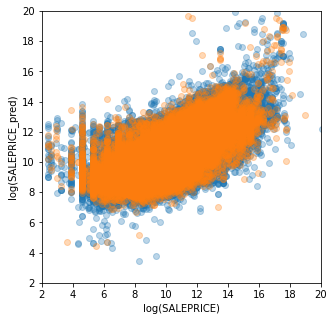

In [48]:
# check the metric of the model
# plot the predictions and the ground truth
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))
plt.figure(figsize=(5,5))
plt.scatter(y_train, y_train_pred, alpha = 0.3)
plt.scatter(y_test, y_test_pred, alpha = 0.3)
plt.xlabel('log(SALEPRICE)')
plt.ylabel('log(SALEPRICE_pred)')
plt.xlim([2, 20])
plt.ylim([2, 20])

train MAE: 3.07e+11
train MSE: 1.67e+28
test MAE: 4.22e+28
test MSE: 1.39e+62


(0.0, 100000000.0)

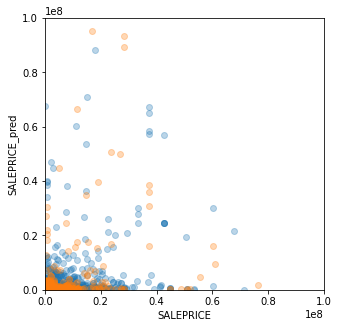

In [49]:
# check the metric of the model
# plot the predictions and the ground truth
print('train MAE: {0:.2e}'.format(mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))))
print('train MSE: {0:.2e}'.format(mean_squared_error(np.exp(y_train), np.exp(y_train_pred))))
#print('train R2: {0:.3f}'.format(r2_score(np.exp(y_train), np.exp(y_train_pred))))
print('test MAE: {0:.2e}'.format(mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))))
print('test MSE: {0:.2e}'.format(mean_squared_error(np.exp(y_test), np.exp(y_test_pred))))
#print('test R2: {0:.3f}'.format(r2_score(np.exp(y_test), np.exp(y_test_pred))))
plt.figure(figsize=(5,5))
plt.scatter(np.exp(y_train), np.exp(y_train_pred), alpha = 0.3)
plt.scatter(np.exp(y_test), np.exp(y_test_pred), alpha = 0.3)
plt.xlabel('SALEPRICE')
plt.ylabel('SALEPRICE_pred')
plt.xlim([0, 1e8])
plt.ylim([0, 1e8])

In [50]:
steps = [('rescale', StandardScaler()),
         ('lr', LassoCV())]
pipe = Pipeline(steps)
lcv = pipe.fit(X_train, y_train)

y_train_pred = lcv.predict(X_train)
y_test_pred = lcv.predict(X_test)

train MAE: 6.18e-01
train MSE: 9.18e-01
train R2: 0.584
test MAE: 6.30e-01
test MSE: 1.02e+00
test R2: 0.546


(2.0, 20.0)

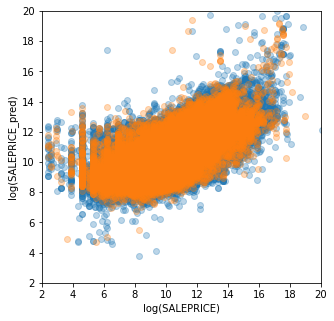

In [51]:
# check the metric of the model
# plot the predictions and the ground truth
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))
plt.figure(figsize=(5,5))
plt.scatter(y_train, y_train_pred, alpha = 0.3)
plt.scatter(y_test, y_test_pred, alpha = 0.3)
plt.xlabel('log(SALEPRICE)')
plt.ylabel('log(SALEPRICE_pred)')
plt.xlim([2, 20])
plt.ylim([2, 20])

train MAE: 8.19e+10
train MSE: 8.53e+26
test MAE: 4.10e+28
test MSE: 1.31e+62


(0.0, 100000000.0)

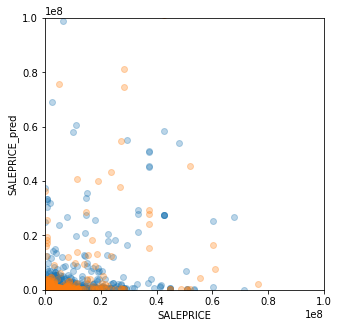

In [52]:
# check the metric of the model
# plot the predictions and the ground truth
print('train MAE: {0:.2e}'.format(mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))))
print('train MSE: {0:.2e}'.format(mean_squared_error(np.exp(y_train), np.exp(y_train_pred))))
#print('train R2: {0:.3f}'.format(r2_score(np.exp(y_train), np.exp(y_train_pred))))
print('test MAE: {0:.2e}'.format(mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))))
print('test MSE: {0:.2e}'.format(mean_squared_error(np.exp(y_test), np.exp(y_test_pred))))
#print('test R2: {0:.3f}'.format(r2_score(np.exp(y_test), np.exp(y_test_pred))))
plt.figure(figsize=(5,5))
plt.scatter(np.exp(y_train), np.exp(y_train_pred), alpha = 0.3)
plt.scatter(np.exp(y_test), np.exp(y_test_pred), alpha = 0.3)
plt.xlabel('SALEPRICE')
plt.ylabel('SALEPRICE_pred')
plt.xlim([0, 1e8])
plt.ylim([0, 1e8])

Text(0.5, 1.0, 'Feature importance using Lasso Model')

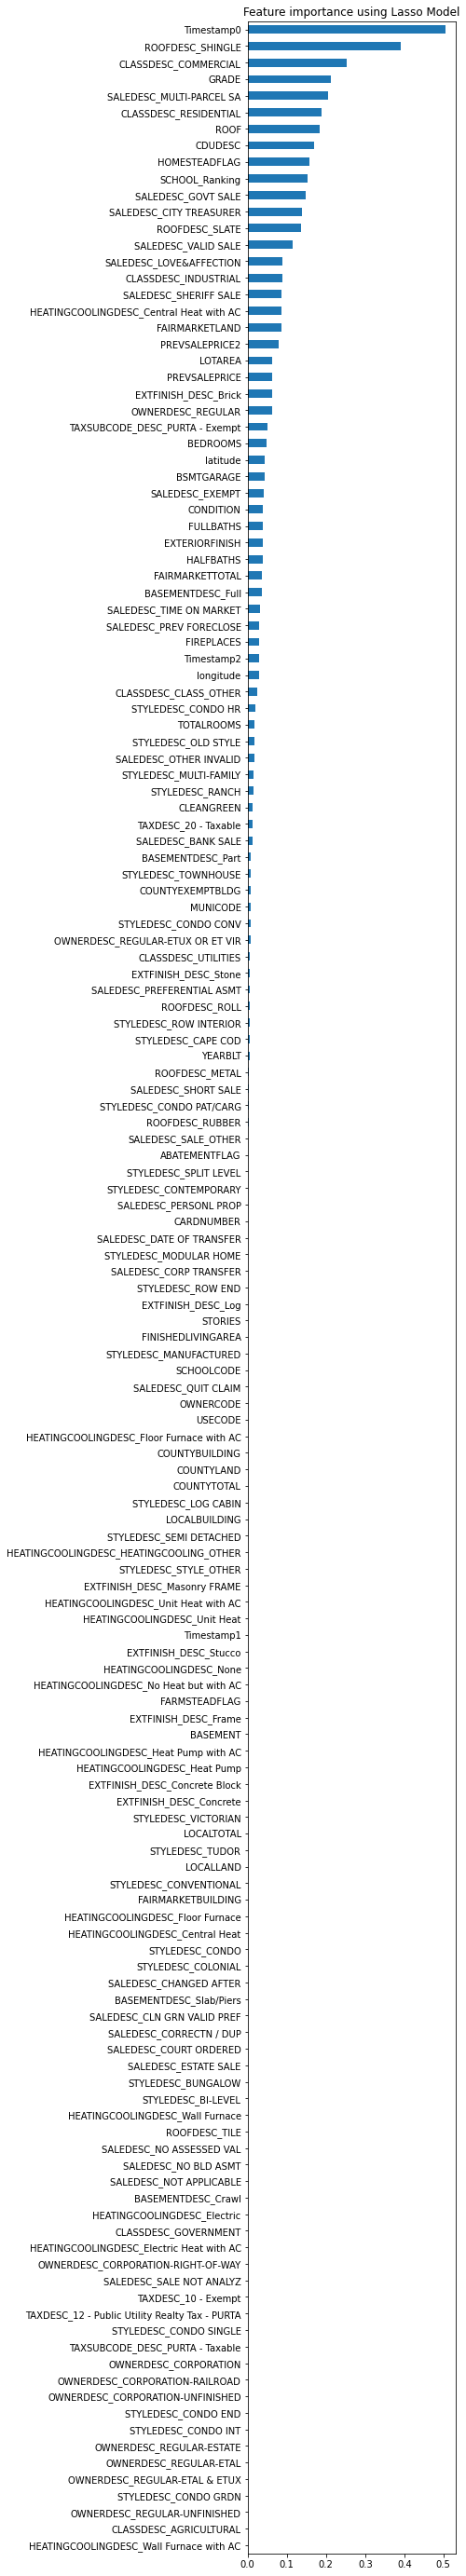

In [53]:
coef = pd.Series(abs(lcv.named_steps['lr'].coef_), index = X_train.columns)
imp_coef = coef.sort_values()

imp_coef.plot(kind = "barh", figsize=(4,50))
plt.title("Feature importance using Lasso Model")

# Tree models

In [58]:
from sklearn.tree import DecisionTreeRegressor

In [59]:
steps = [('Rescale', StandardScaler()),
         ('tree', DecisionTreeRegressor())]
pipe = Pipeline(steps)
dtr = pipe.fit(X_train, y_train)

y_train_pred = dtr.predict(X_train)
y_test_pred = dtr.predict(X_test)

train MAE: 8.55e-05
train MSE: 1.22e-04
train R2: 1.000
test MAE: 4.04e-01
test MSE: 7.87e-01
test R2: 0.649


(2.0, 20.0)

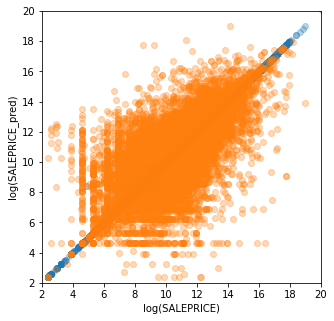

In [60]:
# check the metric of the model
# plot the predictions and the ground truth
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))
plt.figure(figsize=(5,5))
plt.scatter(y_train, y_train_pred, alpha = 0.3)
plt.scatter(y_test, y_test_pred, alpha = 0.3)
plt.xlabel('log(SALEPRICE)')
plt.ylabel('log(SALEPRICE_pred)')
plt.xlim([2, 20])
plt.ylim([2, 20])

train MAE: 1.28e+00
train MSE: 8.03e+04
test MAE: 9.19e+04
test MSE: 1.72e+12


(0.0, 100000000.0)

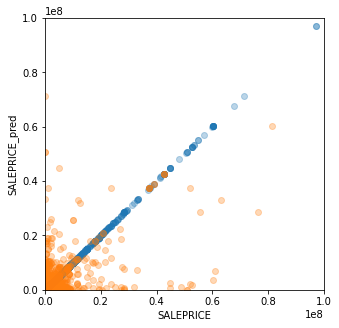

In [61]:
# check the metric of the model
# plot the predictions and the ground truth
print('train MAE: {0:.2e}'.format(mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))))
print('train MSE: {0:.2e}'.format(mean_squared_error(np.exp(y_train), np.exp(y_train_pred))))
#print('train R2: {0:.3f}'.format(r2_score(np.exp(y_train), np.exp(y_train_pred))))
print('test MAE: {0:.2e}'.format(mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))))
print('test MSE: {0:.2e}'.format(mean_squared_error(np.exp(y_test), np.exp(y_test_pred))))
#print('test R2: {0:.3f}'.format(r2_score(np.exp(y_test), np.exp(y_test_pred))))
plt.figure(figsize=(5,5))
plt.scatter(np.exp(y_train), np.exp(y_train_pred), alpha = 0.3)
plt.scatter(np.exp(y_test), np.exp(y_test_pred), alpha = 0.3)
plt.xlabel('SALEPRICE')
plt.ylabel('SALEPRICE_pred')
plt.xlim([0, 1e8])
plt.ylim([0, 1e8])

Text(0.5, 0, 'Importance')

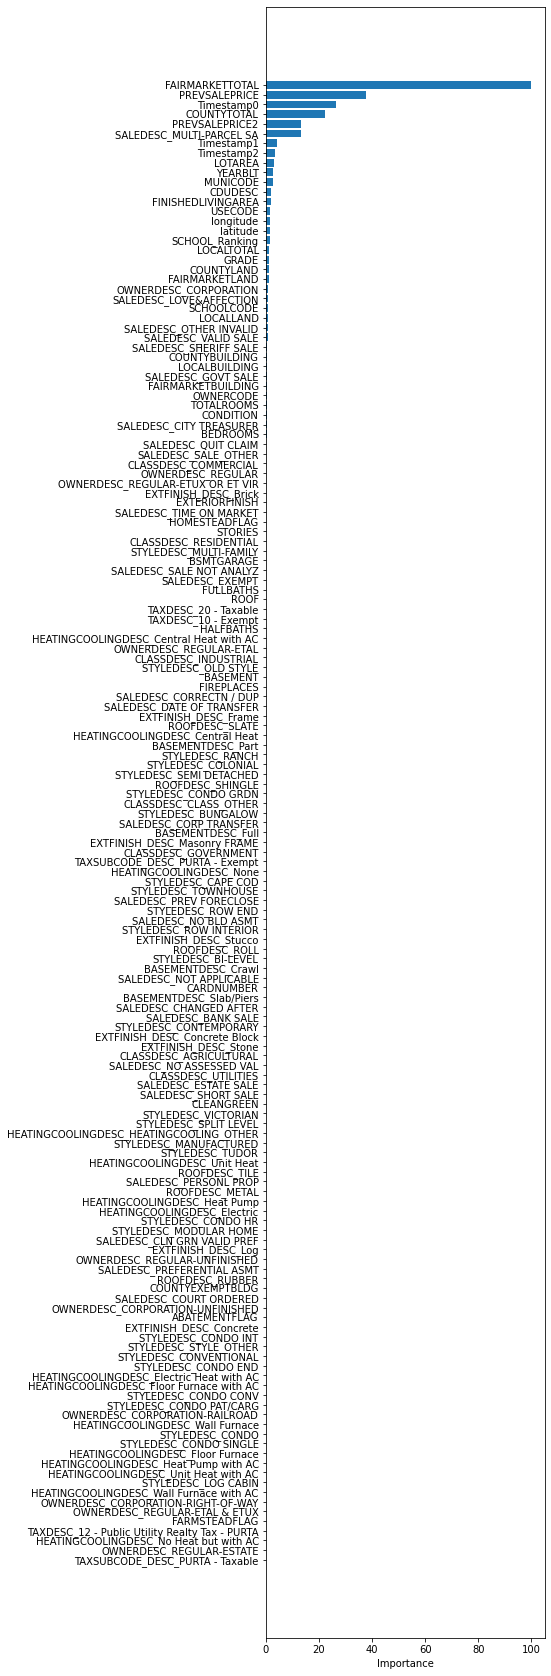

In [77]:
feature_importance = dtr.named_steps['tree'].feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(5, 30))

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.xlabel('Importance')

In [69]:
from sklearn.ensemble import RandomForestRegressor

In [70]:
steps = [('Rescale', StandardScaler()),
         ('tree', RandomForestRegressor())]
pipe = Pipeline(steps)
model_rfr = pipe.fit(X_train, y_train)

y_train_pred = model_rfr.predict(X_train)
y_test_pred = model_rfr.predict(X_test)

train MAE: 1.01e-01
train MSE: 4.87e-02
train R2: 0.978
test MAE: 2.85e-01
test MSE: 3.85e-01
test R2: 0.828


(2.0, 20.0)

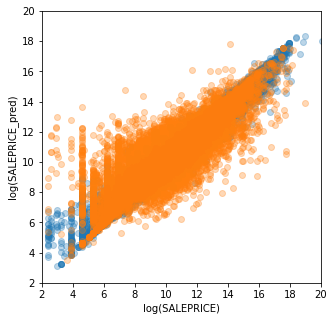

In [71]:
# check the metric of the model
# plot the predictions and the ground truth
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))
plt.figure(figsize=(5,5))
plt.scatter(y_train, y_train_pred, alpha = 0.3)
plt.scatter(y_test, y_test_pred, alpha = 0.3)
plt.xlabel('log(SALEPRICE)')
plt.ylabel('log(SALEPRICE_pred)')
plt.xlim([2, 20])
plt.ylim([2, 20])

train MAE: 2.81e+04
train MSE: 8.73e+11
test MAE: 6.48e+04
test MSE: 1.10e+12


(0.0, 100000000.0)

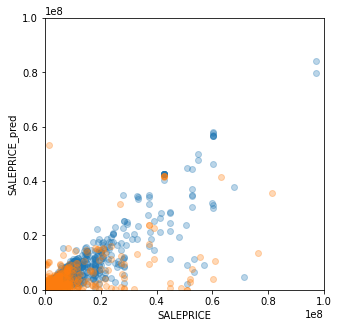

In [72]:
# check the metric of the model
# plot the predictions and the ground truth
print('train MAE: {0:.2e}'.format(mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))))
print('train MSE: {0:.2e}'.format(mean_squared_error(np.exp(y_train), np.exp(y_train_pred))))
#print('train R2: {0:.3f}'.format(r2_score(np.exp(y_train), np.exp(y_train_pred))))
print('test MAE: {0:.2e}'.format(mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))))
print('test MSE: {0:.2e}'.format(mean_squared_error(np.exp(y_test), np.exp(y_test_pred))))
#print('test R2: {0:.3f}'.format(r2_score(np.exp(y_test), np.exp(y_test_pred))))
plt.figure(figsize=(5,5))
plt.scatter(np.exp(y_train), np.exp(y_train_pred), alpha = 0.3)
plt.scatter(np.exp(y_test), np.exp(y_test_pred), alpha = 0.3)
plt.xlabel('SALEPRICE')
plt.ylabel('SALEPRICE_pred')
plt.xlim([0, 1e8])
plt.ylim([0, 1e8])

Text(0.5, 0, 'Importance')

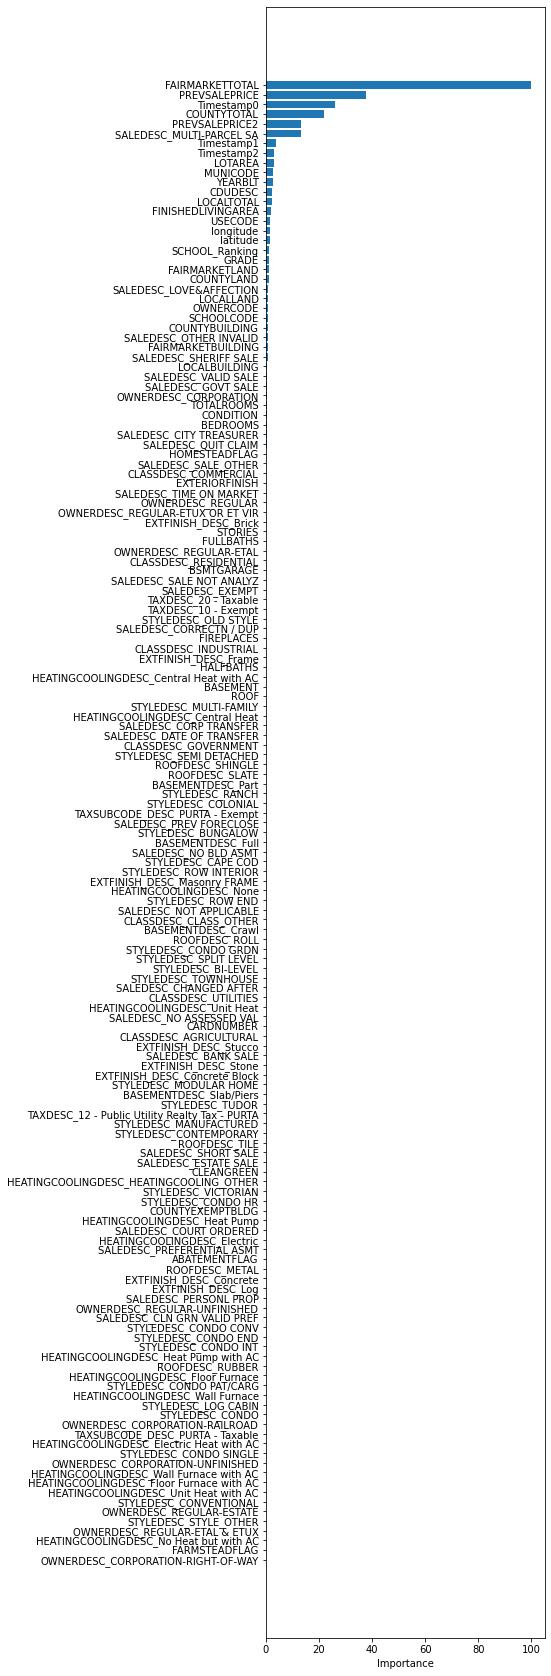

In [78]:
feature_importance = model_rfr.named_steps['tree'].feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(5, 30))

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.xlabel('Importance')

In [63]:
from xgboost import XGBRegressor

In [64]:
steps = [('Rescale', StandardScaler()),
         ('tree', XGBRegressor())]
pipe = Pipeline(steps)
model_xgb = pipe.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

train MAE: 2.91e-01
train MSE: 3.05e-01
train R2: 0.862
test MAE: 3.16e-01
test MSE: 3.89e-01
test R2: 0.827


(2.0, 20.0)

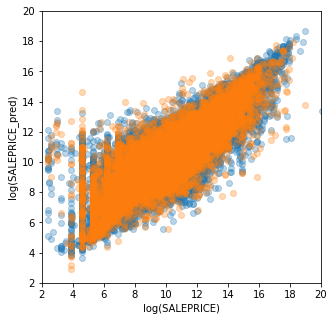

In [65]:
# check the metric of the model
# plot the predictions and the ground truth
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))
plt.figure(figsize=(5,5))
plt.scatter(y_train, y_train_pred, alpha = 0.3)
plt.scatter(y_test, y_test_pred, alpha = 0.3)
plt.xlabel('log(SALEPRICE)')
plt.ylabel('log(SALEPRICE_pred)')
plt.xlim([2, 20])
plt.ylim([2, 20])

train MAE: 5.73e+04
train MSE: 1.17e+12
test MAE: 7.14e+04
test MSE: 1.04e+12


(0.0, 100000000.0)

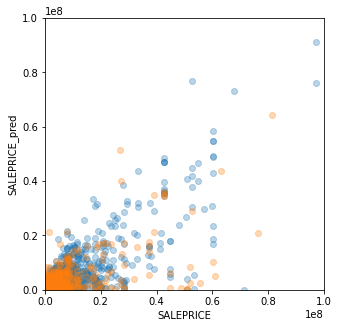

In [66]:
# check the metric of the model
# plot the predictions and the ground truth
print('train MAE: {0:.2e}'.format(mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))))
print('train MSE: {0:.2e}'.format(mean_squared_error(np.exp(y_train), np.exp(y_train_pred))))
#print('train R2: {0:.3f}'.format(r2_score(np.exp(y_train), np.exp(y_train_pred))))
print('test MAE: {0:.2e}'.format(mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))))
print('test MSE: {0:.2e}'.format(mean_squared_error(np.exp(y_test), np.exp(y_test_pred))))
#print('test R2: {0:.3f}'.format(r2_score(np.exp(y_test), np.exp(y_test_pred))))
plt.figure(figsize=(5,5))
plt.scatter(np.exp(y_train), np.exp(y_train_pred), alpha = 0.3)
plt.scatter(np.exp(y_test), np.exp(y_test_pred), alpha = 0.3)
plt.xlabel('SALEPRICE')
plt.ylabel('SALEPRICE_pred')
plt.xlim([0, 1e8])
plt.ylim([0, 1e8])

Text(0.5, 0, 'Importance')

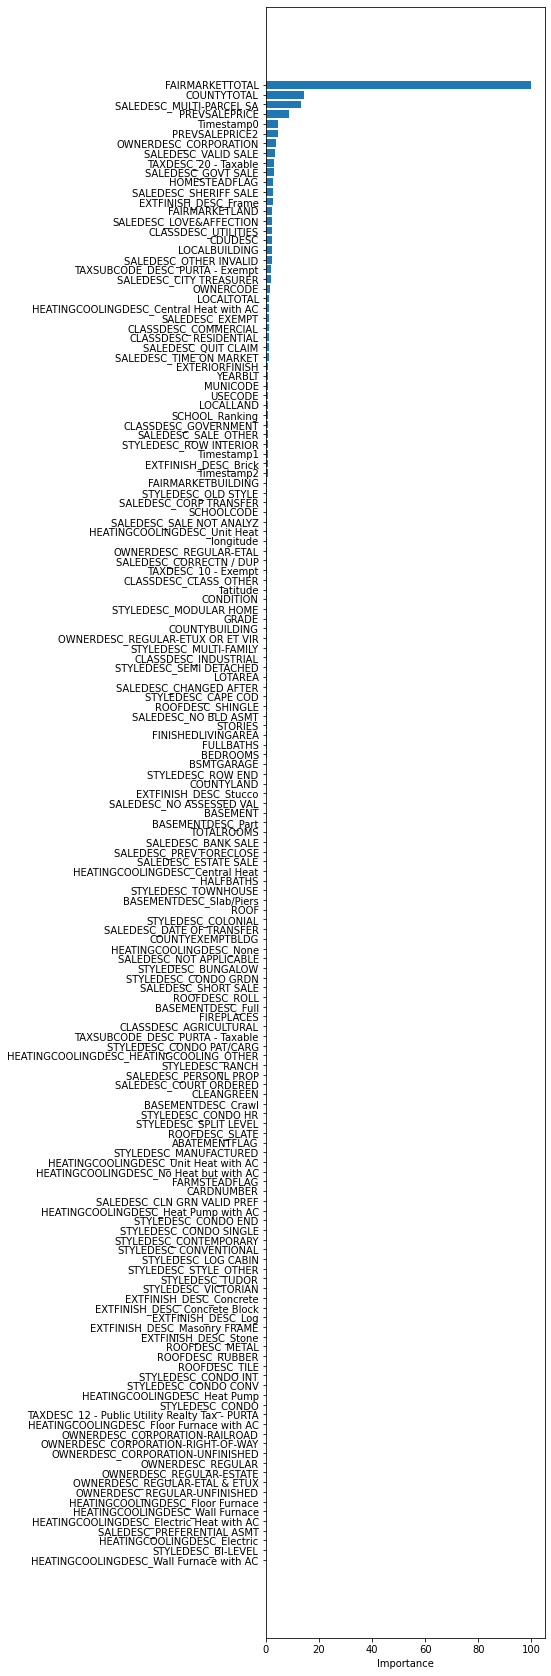

In [76]:
feature_importance = model_xgb.named_steps['tree'].feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(5, 30))

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.xlabel('Importance')

# Tune the XGBoost model

## XGBoost Hyperparameters

In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [13]:
steps = [('Rescale', StandardScaler()),
         ('tree', XGBRegressor())]
pipe = Pipeline(steps)

In [14]:
parameters={'tree__n_estimators': [100, 500, 1000, 2000] #Number of Trees
            }
mse = make_scorer(mean_squared_error,greater_is_better = False)
tuning_model_n_est=GridSearchCV(estimator = pipe, param_grid = parameters, scoring = mse,verbose=123,cv=3)#,n_jobs=-1)
tuning_model_n_est.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START tree__n_estimators=100......................................
[CV 1/3; 1/4] END ......tree__n_estimators=100;, score=-0.375 total time=   9.1s
[CV 2/3; 1/4] START tree__n_estimators=100......................................
[CV 2/3; 1/4] END ......tree__n_estimators=100;, score=-0.365 total time=   9.0s
[CV 3/3; 1/4] START tree__n_estimators=100......................................
[CV 3/3; 1/4] END ......tree__n_estimators=100;, score=-0.376 total time=   9.7s
[CV 1/3; 2/4] START tree__n_estimators=500......................................
[CV 1/3; 2/4] END ......tree__n_estimators=500;, score=-0.355 total time=  42.9s
[CV 2/3; 2/4] START tree__n_estimators=500......................................
[CV 2/3; 2/4] END ......tree__n_estimators=500;, score=-0.345 total time=  40.0s
[CV 3/3; 2/4] START tree__n_estimators=500......................................
[CV 3/3; 2/4] END ......tree__n_estimators=500;, 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Rescale', StandardScaler()),
                                       ('tree',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                

In [69]:
results = tuning_model_n_est.cv_results_
tuning_model_n_est.best_params_

{'tree__n_estimators': 1000}

In [63]:
res = []
for i in range(3):
    res.append(results['split{}_test_score'.format(i)])
df_res = pd.DataFrame(res)
df_res.columns = np.array([100, 500, 1000, 2000])

,100,500,1000,2000
0,-0.374781,-0.355150,-0.353533,-0.354940
1,-0.365144,-0.345228,-0.344765,-0.346931
2,-0.375672,-0.353973,-0.351050,-0.351400


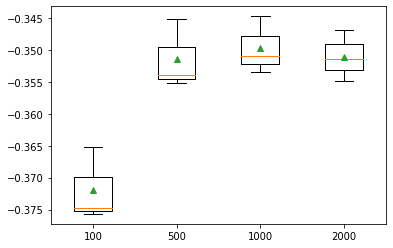

In [65]:
# plot model performance for comparison

plt.boxplot(df_res, labels=df_res.columns, showmeans=True)
plt.show()

In [67]:
parameters={'tree__max_depth': np.arange(1,21,5).tolist(), #Tree Depth
            }
mse = make_scorer(mean_squared_error,greater_is_better = False)
tuning_model_mdp=GridSearchCV(estimator = pipe, param_grid = parameters, scoring = mse,verbose=123,cv=3,n_jobs=-1)
tuning_model_mdp.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Rescale', StandardScaler()),
                                       ('tree',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                

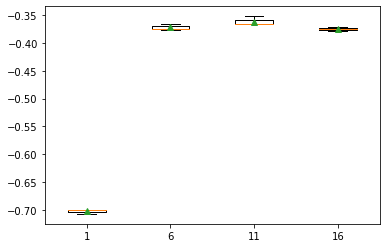

{'tree__max_depth': 11}

In [74]:
results = tuning_model_mdp.cv_results_
res = []
for i in range(3):
    res.append(results['split{}_test_score'.format(i)])
df_res = pd.DataFrame(res)
df_res.columns = np.arange(1,21,5).tolist()
# plot model performance for comparison

plt.boxplot(df_res, labels=df_res.columns, showmeans=True)
plt.show()
tuning_model_mdp.best_params_

In [75]:
parameters={'tree__eta': [0.001, 0.01, 0.1, 1.0] #Learning Rate
            }
mse = make_scorer(mean_squared_error,greater_is_better = False)
tuning_model_eta=GridSearchCV(estimator = pipe, param_grid = parameters, scoring = mse,verbose=123,cv=3,n_jobs=-1)
tuning_model_eta.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Rescale', StandardScaler()),
                                       ('tree',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                

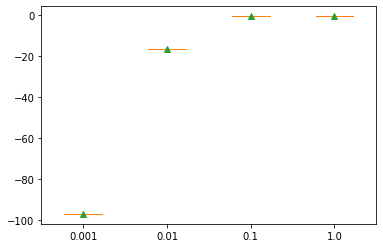

{'tree__eta': 0.1}

In [76]:
results = tuning_model_eta.cv_results_
res = []
for i in range(3):
    res.append(results['split{}_test_score'.format(i)])
df_res = pd.DataFrame(res)
df_res.columns = [0.001, 0.01, 0.1, 1.0] 
# plot model performance for comparison
plt.boxplot(df_res, labels=df_res.columns, showmeans=True)
plt.show()
tuning_model_eta.best_params_

In [85]:
parameters={'tree__subsample': np.arange(0.1, 1.1, 0.1).tolist() #Number of Samples
            }
mse = make_scorer(mean_squared_error,greater_is_better = False)
tuning_model_ss=GridSearchCV(estimator = pipe, param_grid = parameters, scoring = mse,verbose=123,cv=3,n_jobs=-1)
tuning_model_ss.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Rescale', StandardScaler()),
                                       ('tree',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                

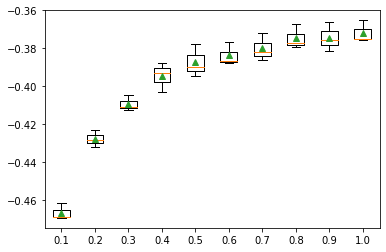

{'tree__subsample': 1.0}

In [90]:
results = tuning_model_ss.cv_results_
res = []
for i in range(3):
    res.append(results['split{}_test_score'.format(i)])
df_res = pd.DataFrame(res)
df_res.columns = np.round(np.arange(0.1, 1.1, 0.1),1).tolist()
# plot model performance for comparison
plt.boxplot(df_res, labels=df_res.columns, showmeans=True)
plt.show()
tuning_model_ss.best_params_

In [88]:
parameters={'tree__colsample_bytree':np.arange(0.1, 1.1, 0.1).tolist()
            }
mse = make_scorer(mean_squared_error,greater_is_better = False)
tuning_model_csb=GridSearchCV(estimator = pipe, param_grid = parameters, scoring = mse,verbose=123,cv=3,n_jobs=-1)
tuning_model_csb.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Rescale', StandardScaler()),
                                       ('tree',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                

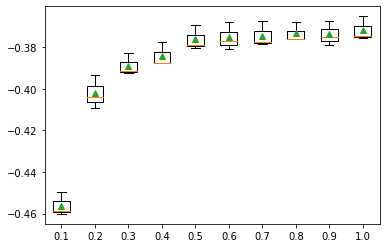

{'tree__colsample_bytree': 1.0}

In [91]:
results = tuning_model_csb.cv_results_
res = []
for i in range(3):
    res.append(results['split{}_test_score'.format(i)])
df_res = pd.DataFrame(res)
df_res.columns = np.round(np.arange(0.1, 1.1, 0.1),1).tolist()
# plot model performance for comparison
plt.boxplot(df_res, labels=df_res.columns, showmeans=True)
plt.show()
tuning_model_csb.best_params_

In [109]:
parameters={'tree__n_estimators': [500, 1000], #Number of Trees
            'tree__max_depth': np.arange(1,21,5).tolist(), #Tree Depth
            'tree__eta': [0.01, 0.1, 1.0], #Learning Rate
            'tree__subsample': [0.2,0.4,0.6,0.8,0.9,1], #Number of Samples
            'tree__colsample_bytree':[0.2,0.4,0.6,0.8,0.9,1]
            }
mse = make_scorer(mean_squared_error,greater_is_better = False)
#tuning_model=GridSearchCV(estimator = pipe, param_grid = parameters, scoring = mse,verbose=123,cv=3,n_jobs=-1)
tuning_model_rs=RandomizedSearchCV (estimator = pipe, param_distributions = parameters, n_iter=500, scoring = mse,verbose=123,cv=3,n_jobs=-1)

In [ ]:
tuning_model_rs.fit(X_train,y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


In [ ]:
parameters={'tree__n_estimators': [500, 1000], #Number of Trees
            'tree__max_depth': np.arange(1,21,5).tolist(), #Tree Depth
            'tree__eta': [0.01, 0.1, 1.0], #Learning Rate
            'tree__subsample': [0.2,0.4,0.6,0.8,0.9,1], #Number of Samples
            'tree__colsample_bytree':[0.2,0.4,0.6,0.8,0.9,1]
            }
mse = make_scorer(mean_squared_error,greater_is_better = False)
tuning_model_gs=GridSearchCV(estimator = pipe, param_grid = parameters, scoring = mse,verbose=123,cv=3,n_jobs=-1)
#tuning_model_rs=RandomizedSearchCV (estimator = pipe, param_distributions = parameters, n_iter=1000, scoring = mse,verbose=123,cv=3,n_jobs=-1)

In [ ]:
tuning_model_gs.fit(X_train,y_train)

# Xgboost Final Model

In [21]:
steps = [('Rescale', StandardScaler()),
         ('tree', XGBRegressor(n_estimators=500, max_depth=11, eta=0.1,
                               subsample=1,colsample_bytree=1))]
pipe = Pipeline(steps)
model_xgb_final = pipe.fit(X_train, y_train)

y_train_pred = model_xgb_final.predict(X_train)
y_test_pred = model_xgb_final.predict(X_test)

train MAE: 1.38e-01
train MSE: 6.20e-02
train R2: 0.972
test MAE: 2.73e-01
test MSE: 3.37e-01
test R2: 0.849


(2.0, 20.0)

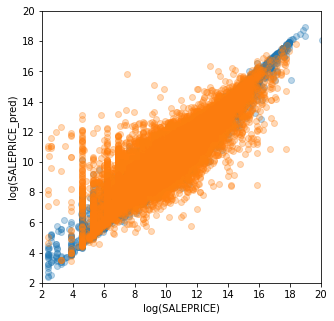

In [22]:
# check the metric of the model
# plot the predictions and the ground truth
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))
plt.figure(figsize=(5,5))
plt.scatter(y_train, y_train_pred, alpha = 0.3)
plt.scatter(y_test, y_test_pred, alpha = 0.3)
plt.xlabel('log(SALEPRICE)')
plt.ylabel('log(SALEPRICE_pred)')
plt.xlim([2, 20])
plt.ylim([2, 20])

train MAE: 2.53e+04
train MSE: 6.98e+11
test MAE: 5.86e+04
test MSE: 4.54e+11


(0.0, 100000000.0)

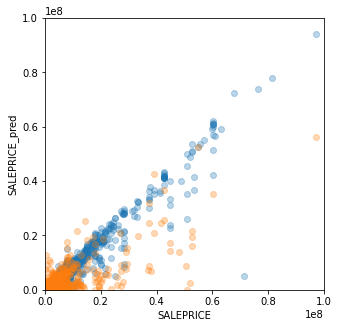

In [23]:
# check the metric of the model
# plot the predictions and the ground truth
print('train MAE: {0:.2e}'.format(mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))))
print('train MSE: {0:.2e}'.format(mean_squared_error(np.exp(y_train), np.exp(y_train_pred))))
#print('train R2: {0:.3f}'.format(r2_score(np.exp(y_train), np.exp(y_train_pred))))
print('test MAE: {0:.2e}'.format(mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))))
print('test MSE: {0:.2e}'.format(mean_squared_error(np.exp(y_test), np.exp(y_test_pred))))
#print('test R2: {0:.3f}'.format(r2_score(np.exp(y_test), np.exp(y_test_pred))))
plt.figure(figsize=(5,5))
plt.scatter(np.exp(y_train), np.exp(y_train_pred), alpha = 0.3)
plt.scatter(np.exp(y_test), np.exp(y_test_pred), alpha = 0.3)
plt.xlabel('SALEPRICE')
plt.ylabel('SALEPRICE_pred')
plt.xlim([0, 1e8])
plt.ylim([0, 1e8])

Text(0.5, 0, 'Importance')

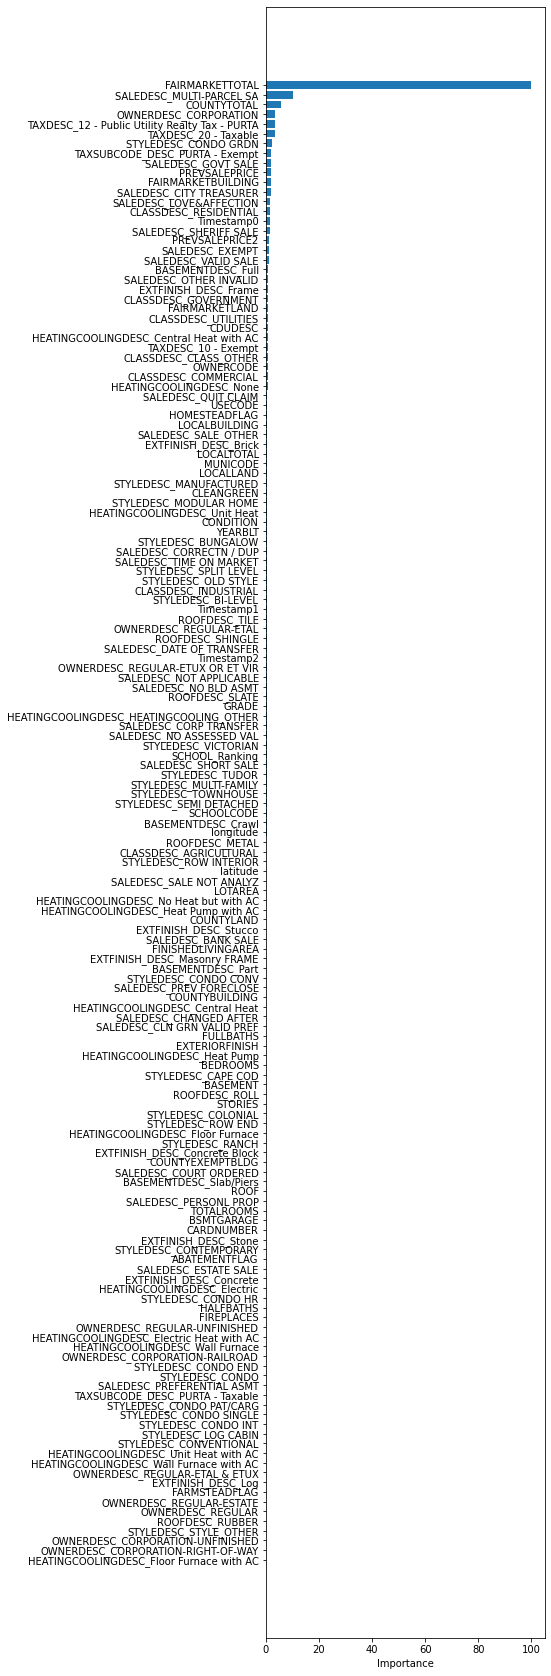

In [24]:
feature_importance = model_xgb_final.named_steps['tree'].feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(5, 30))

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx])
plt.xlabel('Importance')